# Loading stock prices with vnstock

In [1]:
from vnstock import Quote
import pandas as pd

# Define the symbols you want to fetch data for
symbols = ['REE', 'FMC', 'DHC']
print(f"Fetching historical price data for: {symbols}")

# Dictionary to store historical data for each symbol
all_historical_data = {}

# Set date range
start_date = '2024-01-01'
end_date = '2025-03-19'
interval = '1D'

# Fetch historical data for each symbol
for symbol in symbols:
    try:
        print(f"\nProcessing {symbol}...")
        quote = Quote(symbol=symbol)
        
        # Fetch historical price data
        historical_data = quote.history(
            start=start_date,
            end=end_date,
            interval=interval,
            to_df=True
        )
        
        if not historical_data.empty:
            all_historical_data[symbol] = historical_data
            print(f"Successfully fetched {len(historical_data)} records for {symbol}")
        else:
            print(f"No historical data available for {symbol}")
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")

# Export all historical data to a single CSV file
if all_historical_data:
    # Create a combined DataFrame with all data
    combined_data = pd.DataFrame()
    
    for symbol, data in all_historical_data.items():
        if not data.empty:
            # Make a copy of the data and rename columns to include symbol
            temp_df = data.copy()
            # Keep 'time' column as is for merging
            for col in temp_df.columns:
                if col != 'time':
                    temp_df.rename(columns={col: f'{symbol}_{col}'}, inplace=True)
            
            if combined_data.empty:
                combined_data = temp_df
            else:
                combined_data = pd.merge(combined_data, temp_df, on='time', how='outer')
    
    # Sort by time
    if not combined_data.empty:
        combined_data = combined_data.sort_values('time')
        
        # Display sample of combined data
        print("\nSample of combined data:")
        print(combined_data.head(3))
        
        # Export combined data to CSV
        combined_csv_filename = './outputs/all_historical_data.csv'
        combined_data.to_csv(combined_csv_filename, index=False, encoding='utf-8-sig')
        print(f"\nAll historical data exported to {combined_csv_filename}")
    
    # Also create a combined DataFrame for close prices only (for comparison purposes)
    combined_prices = pd.DataFrame()
    
    for symbol, data in all_historical_data.items():
        if not data.empty:
            # Extract time and close price
            temp_df = data[['time', 'close']].copy()
            temp_df.rename(columns={'close': f'{symbol}_close'}, inplace=True)
            
            if combined_prices.empty:
                combined_prices = temp_df
            else:
                combined_prices = pd.merge(combined_prices, temp_df, on='time', how='outer')
    
    # Sort by time
    if not combined_prices.empty:
        combined_prices = combined_prices.sort_values('time')
        
        # Export combined close prices to CSV
        combined_close_csv_filename = './outputs/combined_close_prices.csv'
        combined_prices.to_csv(combined_close_csv_filename, index=False, encoding='utf-8-sig')
        print(f"Combined close price data exported to {combined_close_csv_filename}")
else:
    print("No historical data was fetched for any symbol.")

Phiên bản Vnstock 3.2.5 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnstock --upgrade`.
Lịch sử phiên bản: https://vnstocks.com/docs/tai-lieu/lich-su-phien-ban
Phiên bản hiện tại 3.2.2

Fetching historical price data for: ['REE', 'FMC', 'DHC']

Processing REE...
Successfully fetched 300 records for REE

Processing FMC...
Successfully fetched 300 records for FMC

Processing DHC...
Successfully fetched 300 records for DHC

Sample of combined data:
        time  REE_open  REE_high  REE_low  REE_close  REE_volume  FMC_open  \
0 2024-01-02     48.54     49.21    48.20      48.54      779590     42.97   
1 2024-01-03     48.54     48.79    48.20      48.62      376152     43.54   
2 2024-01-04     48.88     49.64    48.54      48.71      899128     43.88   

   FMC_high  FMC_low  FMC_close  FMC_volume  DHC_open  DHC_high  DHC_low  \
0     44.17    42.97      43.78       18200     36.32     36.46    35.94   
1     43.88    43.50      43.69       26222     36.08     36.41    36.08   
2     44.07    43.64      43.83       19700     36.36     37.50    36.32   

   DHC_close  DHC_volume  
0      36.08      118392  
1      36.36      163177  
2      37.08      319156  

All histo

In [2]:
#print(combined_prices.head())
#print(combined_data.head())

In [3]:
# Set the time column as index and ensure it's datetime format
combined_prices_indexed = combined_prices.copy()
combined_prices_indexed['time'] = pd.to_datetime(combined_prices_indexed['time'])
combined_prices_indexed.set_index('time', inplace=True)

# Calculate daily returns for each stock
returns_df = pd.DataFrame(index=combined_prices_indexed.index)
for symbol in symbols:
    column_name = f'{symbol}_close'
    returns_df[symbol] = combined_prices_indexed[column_name].pct_change()

# Drop the first row which will have NaN values due to pct_change()
returns_df = returns_df.dropna()
# Create an equal-weighted portfolio
portfolio_returns = returns_df.mean(axis=1)


# Loading VNINDEX for benchmarking

In [4]:
from vnstock import Vnstock
symbol='VCI'
source='VCI'
stock = Vnstock().stock(symbol=symbol, source=source)
stock.trading.price_board(['VNINDEX'])
vnindex_data=stock.quote.history(start=start_date, end=end_date)
print(vnindex_data.head())

        time   open   high    low  close   volume
0 2024-01-02  32.55  32.55  31.83  32.02  7175876
1 2024-01-03  31.94  32.32  31.64  32.32  3332592
2 2024-01-04  32.40  33.04  32.13  32.13  9110211
3 2024-01-05  32.25  32.32  31.91  32.17  3825239
4 2024-01-08  32.36  32.78  32.28  32.32  4107758


In [5]:
# Process VNINDEX data
vnindex_data['time'] = pd.to_datetime(vnindex_data['time'])
vnindex_data.set_index('time', inplace=True)
vnindex_data.sort_index(inplace=True)
    
# Calculate VNINDEX returns
benchmark_rets = vnindex_data['close'].pct_change().dropna()
    
# Align benchmark returns with portfolio returns (same dates)
benchmark_rets = benchmark_rets.reindex(portfolio_returns.index)
benchmark_rets = benchmark_rets.fillna(method='ffill')  # Forward fill any missing dates

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


In [6]:
print(benchmark_rets.head())

time
2024-01-03    0.009369
2024-01-04   -0.005879
2024-01-05    0.001245
2024-01-08    0.004663
2024-01-09    0.000000
Name: close, dtype: float64


In [7]:
# 1. Make a copy of the combined_prices DataFrame
prices_df = combined_prices.copy()

# 2. Convert the 'time' column to datetime if it's not already
prices_df['time'] = pd.to_datetime(prices_df['time'])

# 3. Set the 'time' column as the index
prices_df.set_index('time', inplace=True)

# 4. Extract only the close price columns and rename them to just the symbol names
close_price_columns = [col for col in prices_df.columns if '_close' in col]
prices_df = prices_df[close_price_columns]
prices_df.columns = [col.replace('_close', '') for col in close_price_columns]

# 5. Make sure there are no NaN values
prices_df = prices_df.dropna()
print(prices_df.head())

              REE    FMC    DHC
time                           
2024-01-02  48.54  43.78  36.08
2024-01-03  48.62  43.69  36.36
2024-01-04  48.71  43.83  37.08
2024-01-05  48.45  43.88  37.98
2024-01-08  47.95  43.88  39.50


In [8]:
risk_free_rate=0.02
risk_aversion=1

In [9]:
from pypfopt.expected_returns import returns_from_prices
log_returns=False
returns = returns_from_prices(prices_df, log_returns=log_returns)
returns.head()

,REE,FMC,DHC
time,,,
2024-01-03,0.001648,-0.002056,0.007761
2024-01-04,0.001851,0.003204,0.019802
2024-01-05,-0.005338,0.001141,0.024272
2024-01-08,-0.010320,0.000000,0.040021
2024-01-09,-0.012304,0.013218,-0.004810


# Portfolio Optimization (Mean-Variance, Min-volatilty, Max Utility)

## Setting up returns and covariance variables

In [10]:
from pypfopt import EfficientFrontier, risk_models, expected_returns, DiscreteAllocation
from pypfopt.exceptions import OptimizationError
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov #for covariance matrix, get more methods from risk_models
from pypfopt.efficient_frontier import EfficientFrontier


mu=mean_historical_return(prices_df, log_returns=log_returns ) #Optional: add log_returns=True
"""
For most portfolio optimization purposes, the default simple returns pct_change() are adequate, 
but logarithmic returns can provide more robust results in some cases, 
especially when dealing with volatile assets or longer time horizons.
"""
S=sample_cov(prices_df)

### Optional 

In [11]:
"""
from pypfopt.risk_models import CovarianceShrinkage

# Assume 'prices' is a pandas DataFrame of historical asset prices
S = CovarianceShrinkage(prices_df).ledoit_wolf()
"""

"\nfrom pypfopt.risk_models import CovarianceShrinkage\n\n# Assume 'prices' is a pandas DataFrame of historical asset prices\nS = CovarianceShrinkage(prices_df).ledoit_wolf()\n"

## Create an instance of Efficient Frontier

In [12]:
#Createa an instance 
ef=EfficientFrontier(mu,S,weight_bounds=(0, 1)) # Adding weight_bounds is optional, for clarifying short positions, 0 and 1 means weights will be positive

## Generate the EF with simulated portfolios and 3 optimized portfolios

In [13]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import plotting
import matplotlib.pyplot as plt

# Initialize Plotly for Jupyter notebook inline display
import plotly.io as pio
pio.renderers.default = "iframe" #"browser" if want to open in a browser tab

# Create a figure for the efficient frontier
fig = go.Figure()

# Generate points on the efficient frontier using the built-in function
ef_plot = EfficientFrontier(mu, S)
# We'll use matplotlib just to get the data points, but won't display the plot
fig_plt, ax = plt.subplots(figsize=(10, 7))
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=False)

# Extract the efficient frontier line data from the matplotlib plot
ef_line = None
for line in ax.get_lines():
    if line.get_label() == 'Efficient frontier':
        ef_line = line
        break

if ef_line:
    ef_volatility = ef_line.get_xdata()
    ef_returns = ef_line.get_ydata()
    
    # Plot the efficient frontier with Plotly
    fig.add_trace(
        go.Scatter(
            x=ef_volatility,
            y=ef_returns,
            mode='lines',
            name='Efficient Frontier',
            line=dict(color='black', width=2)
        )
    )
plt.close(fig_plt)  # Close the matplotlib figure as we don't need to display it

# Rest of your code remains the same...
# Create a separate instance for max Sharpe ratio portfolio
ef_max_sharpe = EfficientFrontier(mu, S)
ef_max_sharpe.max_sharpe(risk_free_rate=risk_free_rate)
weights_max_sharpe = ef_max_sharpe.clean_weights()
ret_tangent, std_tangent, sharpe = ef_max_sharpe.portfolio_performance(risk_free_rate=risk_free_rate)

# Create another separate instance for min volatility portfolio
ef_min_vol = EfficientFrontier(mu, S)
ef_min_vol.min_volatility()
weights_min_vol = ef_min_vol.clean_weights()
ret_min_vol, std_min_vol, sharpe_min_vol = ef_min_vol.portfolio_performance(risk_free_rate=risk_free_rate)

# Create another separate instance for max utility portfolio
ef_max_utility = EfficientFrontier(mu, S)
ef_max_utility.max_quadratic_utility(risk_aversion=risk_aversion, market_neutral=False)
weights_max_utility = ef_max_utility.clean_weights()
ret_utility, std_utility, sharpe_utility = ef_max_utility.portfolio_performance(risk_free_rate=risk_free_rate)

# Plot the optimal portfolios
fig.add_trace(
    go.Scatter(
        x=[std_tangent],
        y=[ret_tangent],
        mode='markers',
        name='Max Sharpe',
        marker=dict(color='red', size=15, symbol='star')
    )
)

fig.add_trace(
    go.Scatter(
        x=[std_min_vol],
        y=[ret_min_vol],
        mode='markers',
        name='Min Volatility',
        marker=dict(color='green', size=15, symbol='star')
    )
)

fig.add_trace(
    go.Scatter(
        x=[std_utility],
        y=[ret_utility],
        mode='markers',
        name='Max Utility',
        marker=dict(color='blue', size=15, symbol='star')
    )
)

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds

# Create a colorscale for the Sharpe ratios
sharpe_colorscale = px.colors.sequential.Viridis_r

# Plot the random portfolios
fig.add_trace(
    go.Scatter(
        x=stds,
        y=rets,
        mode='markers',
        name='Random Portfolios',
        marker=dict(
            color=sharpes,
            colorscale=sharpe_colorscale,
            colorbar=dict(title='Sharpe Ratio'),
            size=5,
            opacity=0.7
        ),
        showlegend=False
    )
)

# Update the layout
fig.update_layout(
    title='Efficient Frontier with Random Portfolios',
    xaxis_title='Annual Volatility',
    yaxis_title='Expected Annual Return',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
    width=1000,
    height=700,
    template='plotly_white'
)

# Display the figure inline in the notebook
fig.show()

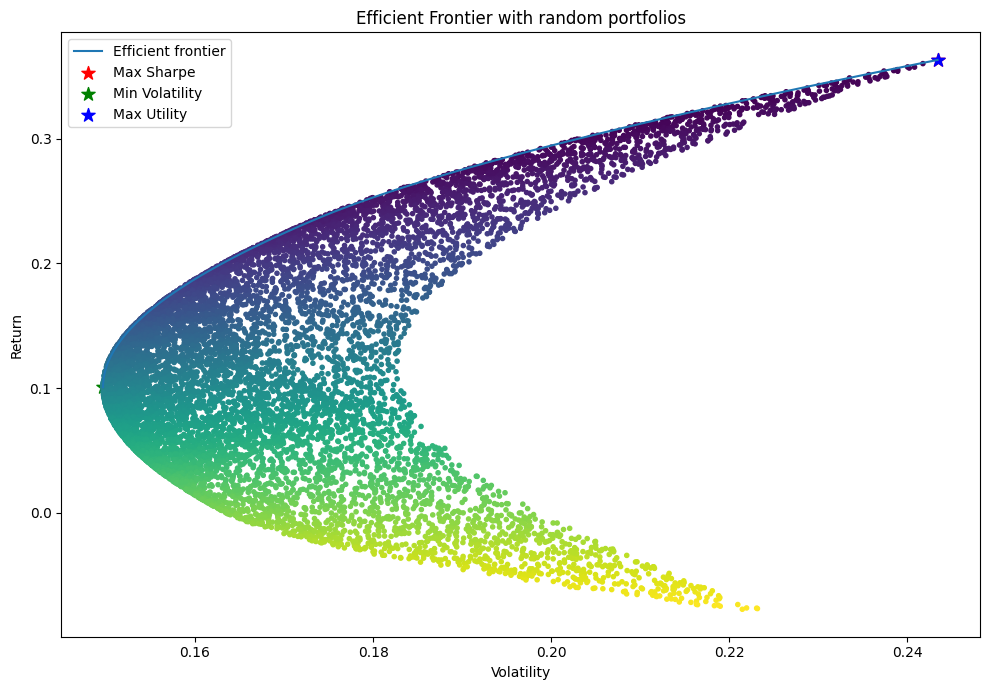

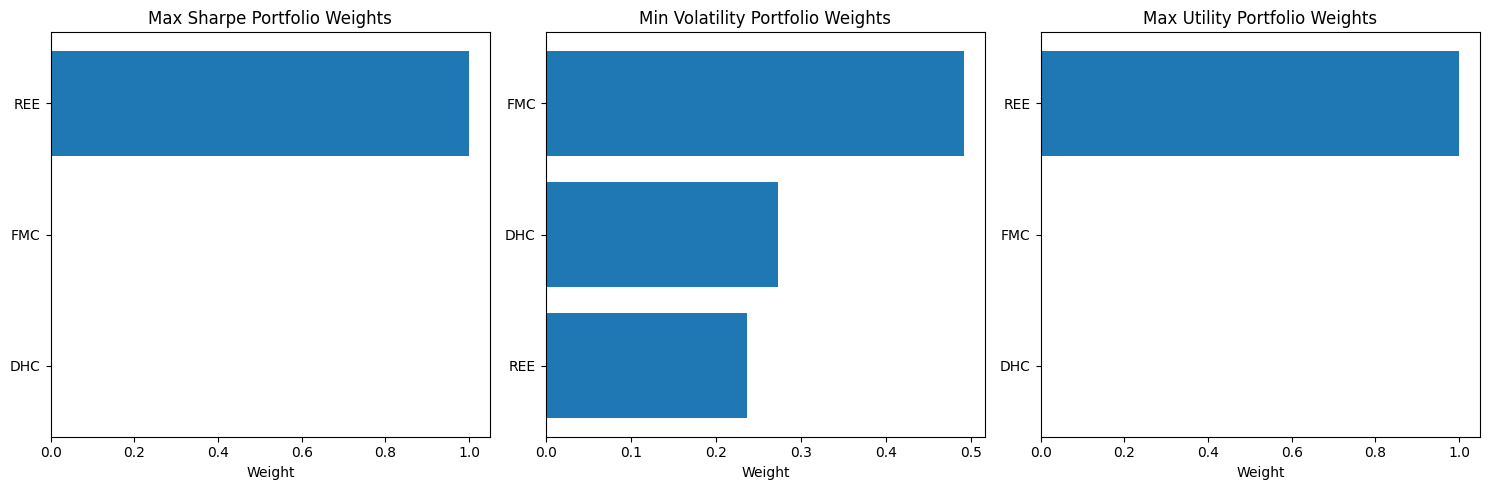

Maximum Sharpe Portfolio:
Expected annual return: 0.3631
Annual volatility: 0.2435
Sharpe Ratio: 1.4093

Minimum Volatility Portfolio:
Expected annual return: 0.1008
Annual volatility: 0.1497
Sharpe Ratio: 0.5397

Maximum Utility Portfolio:
Expected annual return: 0.3631
Annual volatility: 0.2435
Sharpe Ratio: 1.4093
Risk Aversion Parameter: 1


In [14]:
import matplotlib.pyplot as plt
from pypfopt import plotting
import numpy as np
# Create the plot
fig, ax = plt.subplots(figsize=(10, 7))

# Create a new instance for plotting the efficient frontier
ef_plot = EfficientFrontier(mu, S)
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=False)

# Create a separate instance for max Sharpe ratio portfolio
ef_max_sharpe = EfficientFrontier(mu, S)
ef_max_sharpe.max_sharpe(risk_free_rate=risk_free_rate)
weights_max_sharpe = ef_max_sharpe.clean_weights()
ret_tangent, std_tangent, sharpe = ef_max_sharpe.portfolio_performance(risk_free_rate=risk_free_rate)

# Create another separate instance for min volatility portfolio
ef_min_vol = EfficientFrontier(mu, S)
ef_min_vol.min_volatility()
weights_min_vol = ef_min_vol.clean_weights()
ret_min_vol, std_min_vol, sharpe_min_vol = ef_min_vol.portfolio_performance(risk_free_rate=risk_free_rate)

# Create another separate instance for max utility portfolio
ef_max_utility = EfficientFrontier(mu, S)
ef_max_utility.max_quadratic_utility(risk_aversion=risk_aversion, market_neutral=False)
weights_max_utility = ef_max_utility.clean_weights()
ret_utility, std_utility, sharpe_utility = ef_max_utility.portfolio_performance(risk_free_rate=risk_free_rate)

# Plot the tangency portfolio (max Sharpe)
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Plot the minimum volatility portfolio
ax.scatter(std_min_vol, ret_min_vol, marker="*", s=100, c="g", label="Min Volatility")

# Plot the maximum utility portfolio
ax.scatter(std_utility, ret_utility, marker="*", s=100, c="b", label="Max Utility")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef_plot.n_assets), n_samples)
rets = w.dot(ef_plot.expected_returns)
stds = np.sqrt(np.diag(w @ ef_plot.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("./outputs/ef_scatter.png", dpi=200)
plt.show()

# In a separate cell, plot the weights for all three portfolios
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plotting.plot_weights(weights_max_sharpe)
plt.title("Max Sharpe Portfolio Weights")

plt.subplot(1, 3, 2)
plotting.plot_weights(weights_min_vol)
plt.title("Min Volatility Portfolio Weights")

plt.subplot(1, 3, 3)
plotting.plot_weights(weights_max_utility)
plt.title("Max Utility Portfolio Weights")

plt.tight_layout()
plt.show()

# Print the performance metrics for comparison
print("Maximum Sharpe Portfolio:")
print(f"Expected annual return: {ret_tangent:.4f}")
print(f"Annual volatility: {std_tangent:.4f}")
print(f"Sharpe Ratio: {sharpe:.4f}")

print("\nMinimum Volatility Portfolio:")
print(f"Expected annual return: {ret_min_vol:.4f}")
print(f"Annual volatility: {std_min_vol:.4f}")
print(f"Sharpe Ratio: {sharpe_min_vol:.4f}")

print("\nMaximum Utility Portfolio:")
print(f"Expected annual return: {ret_utility:.4f}")
print(f"Annual volatility: {std_utility:.4f}")
print(f"Sharpe Ratio: {sharpe_utility:.4f}")
print(f"Risk Aversion Parameter: {risk_aversion}")

In [19]:
import numpy as np
import pandas as pd
from bokeh.plotting import figure, output_file, save, show
from bokeh.layouts import column, row
from bokeh.palettes import Category10, viridis
from bokeh.models import ColumnDataSource, HoverTool, ColorBar, LinearColorMapper
from bokeh.transform import linear_cmap
from bokeh.models.widgets import Div
from bokeh.io import output_notebook
import os

# Enable Bokeh output in the notebook
output_notebook()

# Create the directory if it doesn't exist
os.makedirs('./outputs', exist_ok=True)

# Create Efficient Frontier plot
ef_fig = figure(
    width=600, height=500,
    title="Efficient Frontier with Random Portfolios",
    x_axis_label="Annual Volatility",
    y_axis_label="Expected Annual Return"
)

# Add random portfolios
color_mapper = LinearColorMapper(palette=viridis(256), low=min(sharpes), high=max(sharpes))
cbar = ColorBar(color_mapper=color_mapper, title="Sharpe Ratio")
ef_fig.add_layout(cbar, 'right')

random_source = ColumnDataSource(data=dict(
    x=stds,
    y=rets,
    sharpe=sharpes
))
ef_fig.scatter('x', 'y', source=random_source, size=5, 
              color=linear_cmap('sharpe', viridis(256), min(sharpes), max(sharpes)),
              alpha=0.5)

# Add the key portfolios
portfolio_names = ['Max Sharpe', 'Min Volatility', 'Max Utility']
portfolios_source = ColumnDataSource(data=dict(
    x=[std_tangent, std_min_vol, std_utility],
    y=[ret_tangent, ret_min_vol, ret_utility],
    port_name=portfolio_names,
    color=['red', 'green', 'blue'],
    ret=[f"{ret_tangent:.4f}", f"{ret_min_vol:.4f}", f"{ret_utility:.4f}"],
    std=[f"{std_tangent:.4f}", f"{std_min_vol:.4f}", f"{std_utility:.4f}"],
    sharpe=[f"{sharpe:.4f}", f"{sharpe_min_vol:.4f}", f"{sharpe_utility:.4f}"]
))

port_scatter = ef_fig.scatter('x', 'y', source=portfolios_source, size=15, 
                             color='color', line_color="black", line_width=2)

hover = HoverTool(renderers=[port_scatter], 
                 tooltips=[
                     ("Portfolio", "@port_name"),
                     ("Return", "@ret"),
                     ("Volatility", "@std"),
                     ("Sharpe", "@sharpe")
                 ])
ef_fig.add_tools(hover)

# Create Time Series plot
ts_fig = figure(
    width=600, height=300,
    title="Asset Prices Time Series",
    x_axis_type="datetime",
    x_axis_label="Date",
    y_axis_label="Price"
)

# Add a line for each asset in prices_df
colors = Category10[10][:len(prices_df.columns)]
for i, col in enumerate(prices_df.columns):
    ts_data = {
        'x': prices_df.index,
        'y': prices_df[col]
    }
    source = ColumnDataSource(data=ts_data)
    ts_fig.line('x', 'y', source=source, line_width=2, color=colors[i % len(colors)], 
                legend_label=str(col))

ts_fig.legend.location = "top_left"
ts_fig.legend.click_policy = "hide"

# Create pie charts for portfolio allocations
def create_pie_chart(weights, title, width=300, height=300):
    radius = 0.8
    
    # Convert weights dictionary to sorted lists
    assets = list(weights.keys())
    values = [weights[asset] for asset in assets]
    
    # Remove assets with zero weight
    filtered_assets = []
    filtered_values = []
    for a, v in zip(assets, values):
        if v > 0.0001:
            filtered_assets.append(str(a))
            filtered_values.append(v)
    
    # Calculate angles for pie chart
    total = sum(filtered_values)
    angles = [val/total * 2*np.pi for val in filtered_values]
    
    # Calculate start and end angles
    start_angles = [sum(angles[:i]) for i in range(len(angles))]
    end_angles = [sum(angles[:i+1]) for i in range(len(angles))]
    
    # Use colors based on number of filtered assets
    pie_colors = colors[:len(filtered_assets)]
    
    # Prepare data for plotting
    source = ColumnDataSource(data=dict(
        asset_name=filtered_assets,
        values=[f"{v:.2%}" for v in filtered_values],
        start_angle=start_angles,
        end_angle=end_angles,
        color=pie_colors,
    ))
    
    # Create figure
    fig = figure(width=width, height=height, title=title,
                tools="hover", tooltips=[("Asset", "@asset_name"), ("Weight", "@values")],
                x_range=(-1.1, 1.1), y_range=(-1.1, 1.1))
    
    # Add wedges for the pie chart
    fig.wedge(x=0, y=0, radius=radius,
             start_angle='start_angle', end_angle='end_angle',
             line_color="white", fill_color='color', source=source)
    
    # Remove axes and grid
    fig.axis.visible = False
    fig.grid.visible = False
    
    return fig

# Create pie charts
pie_max_sharpe = create_pie_chart(weights_max_sharpe, "Max Sharpe Portfolio Weights")
pie_min_vol = create_pie_chart(weights_min_vol, "Min Volatility Portfolio Weights")
pie_max_utility = create_pie_chart(weights_max_utility, "Max Utility Portfolio Weights")

# Add performance metrics as a header div
performance_html = f"""
<div style="padding: 10px; background: #f8f8f8; border: 1px solid #ddd;">
    <h3>Portfolio Performance Metrics</h3>
    <table style="width: 100%; border-collapse: collapse;">
        <tr style="border-bottom: 1px solid #ddd; font-weight: bold;">
            <td>Portfolio</td>
            <td>Expected Return</td>
            <td>Volatility</td>
            <td>Sharpe Ratio</td>
        </tr>
        <tr style="border-bottom: 1px solid #ddd;">
            <td>Max Sharpe</td>
            <td>{ret_tangent:.4f}</td>
            <td>{std_tangent:.4f}</td>
            <td>{sharpe:.4f}</td>
        </tr>
        <tr style="border-bottom: 1px solid #ddd;">
            <td>Min Volatility</td>
            <td>{ret_min_vol:.4f}</td>
            <td>{std_min_vol:.4f}</td>
            <td>{sharpe_min_vol:.4f}</td>
        </tr>
        <tr>
            <td>Max Utility (Risk Aversion: {risk_aversion})</td>
            <td>{ret_utility:.4f}</td>
            <td>{std_utility:.4f}</td>
            <td>{sharpe_utility:.4f}</td>
        </tr>
    </table>
</div>
"""
header = Div(text=performance_html, width=1200)

# Create layout with two columns
pie_row = row(pie_max_sharpe, pie_min_vol, pie_max_utility)
right_column = column(ts_fig, pie_row)
main_row = row(ef_fig, right_column)
layout = column(header, main_row)

# Display the visualization in the notebook
show(layout)

# Also save to HTML file
output_file('./outputs/index.html', title="Portfolio Optimization")
save(layout)
print(f"Portfolio visualization saved to './outputs/index.html'")

Loading BokehJS ...

Portfolio visualization saved to './outputs/index.html'


### More examples of optimization methods

In [15]:
"""
#Optimizers, apply the optimizer of choice after instantiating EfficientFrontier(mu,S)
#Portfolio with max sharpe ratio
ef.max_sharpe(risk_free_rate=risk_free_rate)
#ef.min_volatility()
ef.portfolio_performance(risk_free_rate=risk_free_rate)

#Optimizer
#Maximise return for a target risk. The resulting portfolio will have a volatility less than the target (but not guaranteed to be equal).
target_volatility=0.15
conditional_volatility_portfolio=ef.efficient_risk(target_volatility=target_volatility,market_neutral=True)
print(conditional_volatility_portfolio)
#ef.portfolio_performance(risk_free_rate=risk_free_rate) #re-calculate portfolio performance on conditional_volatility_portfolio 

#Optimizer
#Calculate the ‘Markowitz portfolio’, minimising volatility for a given target return.
target_return=0.2
conditional_return_portfolio=ef.efficient_return(target_return=target_return, market_neutral=False) #market_neutral=False means no shorting allowed
print(conditional_return_portfolio)
ef.portfolio_performance(risk_free_rate=risk_free_rate) #re-calculate portfolio performance on conditional_return_portfolio

#Optimizer
#Maximise the given quadratic utility
max_utility_portfolio=ef.max_quadratic_utility(risk_aversion=risk_aversion, market_neutral=False)
print(max_utility_portfolio)
#ef.portfolio_performance(risk_free_rate=risk_free_rate)

#Optimizer 
# minimize semivariance
min_semivariance_portfolio=ef.min_semivariance(target_return=target_return, market_neutral=False)
print(min_semivariance_portfolio)
#ef.portfolio_performance(risk_free_rate=risk_free_rate)

#Optimizer 
# minimize CVaR.
min_cvar_portfolio=ef.min_cvar(target_return=target_return, market_neutral=False)
print(min_cvar_portfolio)
#ef.portfolio_performance(risk_free_rate=risk_free_rate)
"""

'\n#Optimizers, apply the optimizer of choice after instantiating EfficientFrontier(mu,S)\n#Portfolio with max sharpe ratio\nef.max_sharpe(risk_free_rate=risk_free_rate)\n#ef.min_volatility()\nef.portfolio_performance(risk_free_rate=risk_free_rate)\n\n#Optimizer\n#Maximise return for a target risk. The resulting portfolio will have a volatility less than the target (but not guaranteed to be equal).\ntarget_volatility=0.15\nconditional_volatility_portfolio=ef.efficient_risk(target_volatility=target_volatility,market_neutral=True)\nprint(conditional_volatility_portfolio)\n#ef.portfolio_performance(risk_free_rate=risk_free_rate) #re-calculate portfolio performance on conditional_volatility_portfolio \n\n#Optimizer\n#Calculate the ‘Markowitz portfolio’, minimising volatility for a given target return.\ntarget_return=0.2\nconditional_return_portfolio=ef.efficient_return(target_return=target_return, market_neutral=False) #market_neutral=False means no shorting allowed\nprint(conditional_retu

### List stocks by sectors and icb

In [16]:
from vnstock import Listing
sectors=stock.listing.symbols_by_industries()
sectors

,symbol,organ_name,icb_name3,icb_name2,icb_name4,com_type_code,icb_code1,icb_code2,icb_code3,icb_code4
0,AAH,Công ty Cổ phần Hợp Nhất,Khai khoáng,Tài nguyên Cơ bản,Khai thác Than,CT,1000,1700,1770,1771
1,BMK,Công ty Cổ Phần Kỹ thuật Nhiệt Mèo Đen,Xây dựng và Vật liệu,Xây dựng và Vật liệu,Vật liệu xây dựng & Nội thất,CT,2000,2300,2350,2353
2,VTL,Công ty Cổ phần Vang Thăng Long,Bia và đồ uống,Thực phẩm và đồ uống,Vang & Rượu mạnh,CT,3000,3500,3530,3535
3,GCF,Công ty Cổ phần Thực phẩm G.C,Sản xuất thực phẩm,Thực phẩm và đồ uống,Thực phẩm,CT,3000,3500,3570,3577
4,HLO,Công Ty Cổ Phần Công Nghệ Ha Lô,Điện tử & Thiết bị điện,Hàng & Dịch vụ Công nghiệp,Hàng điện & điện tử,CT,2000,2700,2730,2733
...,...,...,...,...,...,...,...,...,...,...
1589,XPH,Công ty Cổ phần Xà phòng Hà Nội,Hàng cá nhân,Hàng cá nhân & Gia dụng,Hàng cá nhân,CT,3000,3700,3760,3767
1590,XMP,Công ty Cổ phần Thủy điện Xuân Minh,Sản xuất & Phân phối Điện,"Điện, nước & xăng dầu khí đốt",Sản xuất & Phân phối Điện,CT,7000,7500,7530,7535
1591,YBC,Công ty Cổ phần Xi măng và Khoáng sản Yên Bái,Xây dựng và Vật liệu,Xây dựng và Vật liệu,Vật liệu xây dựng & Nội thất,CT,2000,2300,2350,2353
1592,YBM,Công ty Cổ phần Khoáng sản Công nghiệp Yên Bái,Khai khoáng,Tài nguyên Cơ bản,Khai khoáng,CT,1000,1700,1770,1775


In [17]:
#Check if a stock in the portfolio is on the list and get relavant information
sectors[sectors['symbol']== 'FMC']

,symbol,organ_name,icb_name3,icb_name2,icb_name4,com_type_code,icb_code1,icb_code2,icb_code3,icb_code4
1310,FMC,Công ty Cổ phần Thực phẩm Sao Ta,Sản xuất thực phẩm,Thực phẩm và đồ uống,Nuôi trồng nông & hải sản,CT,3000,3500,3570,3573


In [18]:
#Get a list of unique sectors with icb3
unique_sectors=sectors['icb_name3'].unique() #np array
pd.DataFrame(unique_sectors)

,0
0,Khai khoáng
1,Xây dựng và Vật liệu
2,Bia và đồ uống
3,Sản xuất thực phẩm
4,Điện tử & Thiết bị điện
5,Hóa chất
6,Tư vấn & Hỗ trợ Kinh doanh
7,Hàng cá nhân
8,Bất động sản
9,Ngân hàng


# Create a sceener with a pre-defind criteria

In [19]:

from vnstock import Screener
from vnstock import Vnstock
# Initialize Vnstock with a symbol and source
symbol = 'VCI'  # Any valid symbol
source = 'VCI'  # Same as symbol for simplicity
stock = Vnstock().stock(symbol=symbol, source=source)
params = {
            "exchangeName": "HOSE,HNX,UPCOM",
            "marketCap": (100, 1000),
            "dividendYield": (5, 10)
        }

full_params = {
    # General Information
    "exchangeName": "HOSE,HNX,UPCOM",
    "hasFinancialReport": 1,  # Has the latest financial report
    "industryName": "Banks,Technology,Real Estate",
    "marketCap": (500, 10000),  # Market cap between 500-10000 billion VND
    "priceNearRealtime": (10, 100),  # Price between 10-100 VND
    "foreignVolumePercent": (5, 100),  # At least 5% foreign trading volume
    "alpha": (0.1, None),  # Positive alpha (excess return vs market)
    "beta": (0.8, 1.2),  # Beta close to market
    "freeTransferRate": (30, None),  # At least 30% freely transferable shares
    
    # Growth Metrics
    "revenueGrowth1Year": (10, None),  # At least 10% revenue growth in past year
    "revenueGrowth5Year": (5, None),  # At least 5% average revenue growth over 5 years
    "epsGrowth1Year": (5, None),  # At least 5% EPS growth in past year
    "epsGrowth5Year": (3, None),  # At least 3% average EPS growth over 5 years
    "lastQuarterRevenueGrowth": (0, None),  # Positive revenue growth in last quarter
    "lastQuarterProfitGrowth": (0, None),  # Positive profit growth in last quarter
    
    # Financial Ratios
    "grossMargin": (20, None),  # At least 20% gross margin
    "netMargin": (10, None),  # At least 10% net margin
    "roe": (15, None),  # At least 15% return on equity
    "doe": (5, None),  # At least 5% dividend on equity
    "dividendYield": (3, None),  # At least 3% dividend yield
    "pe": (5, 20),  # P/E between 5 and 20
    "pb": (0.5, 3),  # P/B between 0.5 and 3
    "evEbitda": (None, 15),  # EV/EBITDA below 15
    "netCashPerMarketCap": (0.1, None),  # Net cash at least 10% of market cap
    
    # Price & Volume Movements
    "totalTradingValue": (1, None),  # At least 1 billion VND trading value today
    "avgTradingValue20Day": (0.5, None),  # At least 0.5 billion VND average trading value over 20 days
    "priceGrowth1Week": (-5, 5),  # Price change between -5% and +5% in last week
    "priceGrowth1Month": (-10, 10),  # Price change between -10% and +10% in last month
    "percent1YearFromPeak": (None, -20),  # At least 20% below 1-year peak
    "percent1YearFromBottom": (10, None),  # At least 10% above 1-year bottom
    
    # Technical Indicators
    "rsi14": (30, 70),  # RSI between 30 and 70
    "priceVsSMA20": "ABOVE",  # Price above 20-day SMA
    "priceVsSMA50": "ABOVE",  # Price above 50-day SMA
    "volumeVsVSma20": (1, None),  # Volume above 20-day volume SMA
    
    # Market Behavior
    "strongBuyPercentage": (50, None),  # At least 50% strong buy signals
    "foreignTransaction": "buyMoreThanSell",  # Foreign investors buying more than selling
    
    # TCBS Ratings
    "stockRating": (3, None),  # Stock rating at least 3 out of 5
    "businessModel": (3, None),  # Business model rating at least 3 out of 5
    "financialHealth": (3, None)  # Financial health rating at least 3 out of 5
}

df_filtered = stock.screener.stock(params = params, limit=1700) #drop_lang='vi' 
df_filtered


,ticker,exchange,industry,market_cap,roe,stock_rating,business_operation,business_model,financial_health,alpha,...,profit_last_4q,last_quarter_revenue_growth,second_quarter_revenue_growth,last_quarter_profit_growth,second_quarter_profit_growth,pct_1y_from_peak,pct_away_from_hist_peak,pct_1y_from_bottom,pct_off_hist_bottom,price_vs_sma100
0,ABT,HSX,Thực phẩm và đồ uống,510,21.9,3.4,3.6,3.0,4.8,0.1,...,112.5,34.4,8.2,98.2,208.6,-9.4,-6.7,39.7,369.7,Giá nằm dưới SMA(100)
1,ADP,UPCOM,Xây dựng và Vật liệu,722,28.1,3.7,3.4,3.0,5.0,0.1,...,84.8,20.7,13.8,-2.2,-24.2,NaN,NaN,NaN,NaN,None
2,BAX,HNX,Xây dựng và Vật liệu,304,12.5,2.8,2.3,3.5,5.0,0.0,...,26.5,7.6,-16.5,-1.2,-32.6,-12.4,-51.1,16.5,324.0,Giá nằm dưới SMA(100)
3,BSQ,UPCOM,Thực phẩm và đồ uống,886,9.7,2.7,2.0,3.0,3.6,0.1,...,82.4,-16.2,12.2,-66.3,45.4,NaN,NaN,NaN,NaN,None
4,CCI,HSX,"Điện, nước & xăng dầu khí đốt",391,14.4,2.8,1.7,3.5,4.2,0.1,...,36.5,-12.5,-9.2,31.1,-75.9,-11.2,-30.9,24.7,772.9,Giá nằm trên SMA(100)
5,COM,HSX,Bán lẻ,438,5.8,2.7,1.3,3.0,4.2,0.1,...,25.7,-16.6,-16.2,-31.2,-40.5,-4.2,-50.4,36.9,235.8,Giá nằm trên SMA(100)
6,DRL,HSX,"Điện, nước & xăng dầu khí đốt",535,36.7,2.8,3.1,3.6,4.2,0.0,...,46.3,16.5,-0.2,14.5,-10.4,-7.0,-7.9,6.2,1091.3,Giá nằm trên SMA(100)
7,DSN,HSX,Du lịch và Giải trí,550,29.4,2.9,3.1,3.5,4.2,-0.1,...,85.0,-25.4,-32.9,-47.1,-37.2,-16.8,-16.0,1.1,1189.4,Giá nằm dưới SMA(100)
8,EBS,HNX,Truyền thông,105,11.8,NaN,2.2,NaN,5.0,0.1,...,16.3,42.8,15.3,51.9,38.6,NaN,NaN,NaN,NaN,None
9,EIC,UPCOM,Xây dựng và Vật liệu,820,12.3,2.8,3.0,3.1,4.2,0.1,...,50.4,800.5,-5.8,-72.4,-117.8,NaN,NaN,NaN,NaN,None


In [20]:
#screener_df = stock.screener.stock(params={"exchangeName": "HOSE,HNX,UPCOM"}, limit=1700)
#screener_df

# Hierarchical Risk Parity

In [21]:
from pypfopt import HRPOpt
hrp = HRPOpt(returns=returns) #create the object
weights = hrp.optimize() #optimize the object
weights

OrderedDict([('DHC', np.float64(0.280008567778799)),
             ('FMC', np.float64(0.4150523222546779)),
             ('REE', np.float64(0.30493910996652307))])

### Round the weights and save to a json file for webview

In [22]:
hrp.clean_weights()
#Saving weights to csv
hrp.save_weights_to_file("./outputs/hrp_weights.json")


# Dollars Allocation

In [23]:
# This extracts the last row of prices_df and converts it to a Series

from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
latest_prices = get_latest_prices(prices_df) #Alternatives: latest_prices = prices_df.iloc[-1]
# Assuming you already have optimized weights (e.g., from max_sharpe or min_volatility)
# And a total portfolio value
portfolio_value = 100000  # 1 million VND

# You can use either the Series or dict version of latest_prices
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=portfolio_value)
allocation, leftover = da.greedy_portfolio()

### Plotting with the HRP portfolio with pypfopt

<Axes: >

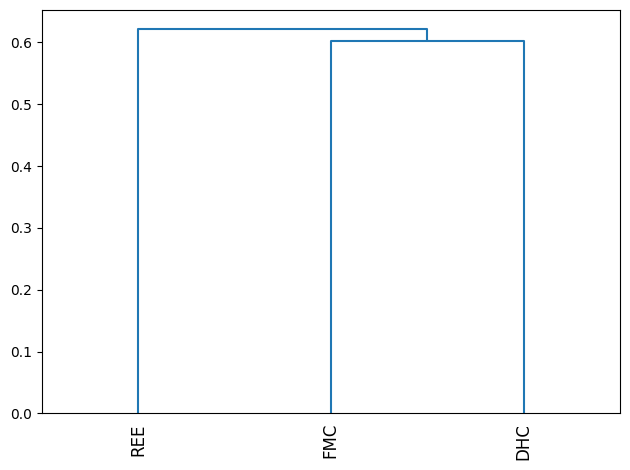

In [24]:
from pypfopt import plotting
plotting.plot_dendrogram(hrp, ax=None, show_tickers=True)

### Plot the covariance

<Axes: >

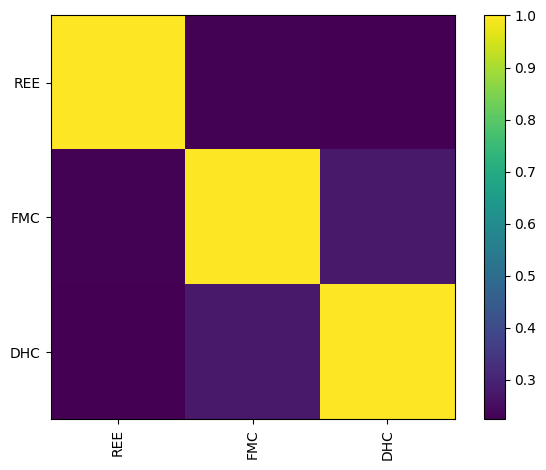

In [25]:
# Plot the covariance
plotting.plot_covariance(S, plot_correlation=True, show_tickers=True)

# Riskfolio

In [26]:
import warnings
#warnings.filterwarnings("ignore")
import riskfolio as rp
"""
# Building the portfolio object
port = rp.Portfolio(returns=returns)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)
"""
# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

#w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
#display(w.T)



### Plot the weights on a pie chart

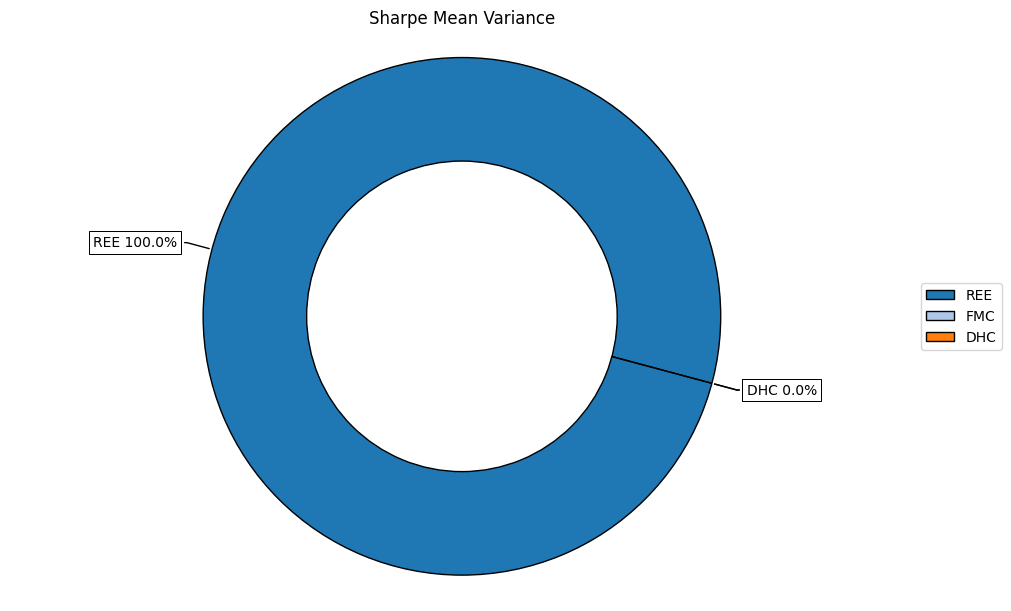

In [27]:
# Plotting the composition of the portfolio
#Convert weights_max_sharpe variable to series or use w=w to use the wieghts generated by riskfolio

ax = rp.plot_pie(w=pd.Series(weights_max_sharpe), title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### Setting up risk measures variables

In [28]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']
"""
w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms
"""

'\nw_s = pd.DataFrame([])\n\nfor i in rms:\n    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)\n    w_s = pd.concat([w_s, w], axis=1)\n    \nw_s.columns = rms\n'

In [29]:
#w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

### Plot the historical compounded cummulative returns

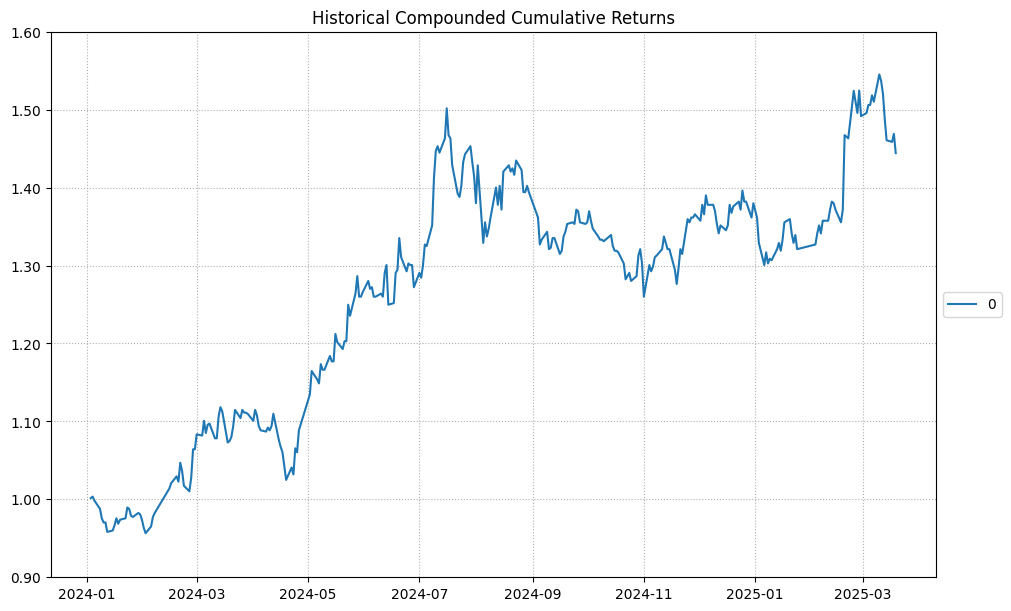

In [30]:
ax = rp.plot_series(returns=returns,
                    w=pd.Series(weights_max_sharpe),
                    cmap='tab20',
                    height=6,
                    width=10,
                    ax=None)

### Plot risk contribution on a bar chart

In [31]:
ax = rp.plot_risk_con(w=weights_max_sharpe,
                      cov=S, #using covariance from pypfopt lib, which in this case is sample_cov
                      returns=returns,
                      rm=rm,
                      rf=risk_free_rate,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)

ValueError: w must be a one column DataFrame or Series

### Plot a histogram of returns distribution

In [ ]:
ax = rp.plot_hist(returns=returns,
                  w=pd.Series(weights_max_sharpe),
                  alpha=0.05,
                  bins=50,
                  height=6,
                  width=10,
                  ax=None)

In [ ]:
ax = rp.plot_range(returns=returns,
                   w=pd.Series(weights_max_sharpe),
                   alpha=0.05,
                   a_sim=100,
                   beta=None,
                   b_sim=None,
                   bins=50,
                   height=6,
                   width=10,
                   ax=None)

In [ ]:
"""
ax = rp.jupyter_report(returns,
                       w,
                       rm='MV',
                       rf=0,
                       alpha=0.05,
                       height=6,
                       width=14,
                       others=0.05,
                       nrow=25)
"""                       

### Plot the full report

In [ ]:
ax = rp.plot_table(returns=returns,
                   w=pd.Series(weights_max_sharpe),
                   MAR=0,
                   alpha=0.05,
                   ax=None)

### Save a report to excel

In [ ]:
rp.excel_report(returns,
                w,
                rf=risk_free-rate, # could =0 or =risk_free-rate
                alpha=0.05,
                t_factor=252,
                ini_days=1,
                days_per_year=252,
                name="./outputs/report")

In [ ]:
ax = rp.plot_factor_risk_con(w=pd.Series(weights_max_sharpe),
                             cov=S,
                             returns=returns,
                             factors=returns,
                             B=None,
                             const=True,
                             rm=rm,
                             rf=0,
                             feature_selection="PCR", #Indicate the method used to estimate the loadings matrix, PCR or stepwise
                             n_components=0.95,
                             height=6,
                             width=10,
                             t_factor=252,
                             ax=None)

In [ ]:
ax = rp.plot_drawdown(returns=returns,
                      w=pd.Series(weights_max_sharpe), # or w=w
                      alpha=0.05,
                      height=8,
                      width=10,
                      ax=None)

# Quantstats

In [ ]:
import quantstats as qs
qs.extend_pandas()

In [ ]:
#View a complete list of available metrics
[f for f in dir(qs.stats) if f[0] != '_'] 

In [ ]:
qs.stats.avg_loss(portfolio_returns)

In [ ]:
#View a complete list of available plots, some will not work in pandas 3.0 
[f for f in dir(qs.plots) if f[0] != '_']

In [ ]:
qs.plots.rolling_beta(portfolio_returns,benchmark_rets) #benchmark_rets should have been index fund rather than VNINDEX

# Constraints Portfolio

In [ ]:
import pandas as pd

# Function to create a sector mapping dictionary from the grouped sectors
def create_sector_mapper(grouped_data):
    sector_mapper = {}
    
    for sector_name, group_df in grouped_data:
        # For each stock in this sector group, add to the dictionary
        for _, row in group_df.iterrows():
            sector_mapper[row['symbol']] = sector_name
    
    return sector_mapper

# Group by sector
grouped = sectors.groupby('icb_name3')

# Create the sector mapper dictionary
sector_mapper = create_sector_mapper(grouped)

print(f"Created sector mapper for {len(sector_mapper)} symbols")

In [ ]:
#sector_mapper

In [ ]:
sector_lower = {"Sản xuất & Phân phối Điện": 0.1, "Sản xuất thực phẩm": 0.05}  # Min percentages
sector_upper = {"Sản xuất & Phân phối Điện": 0.4, "Sản xuất thực phẩm/Gas": 0.2}      # Max percentages

In [ ]:
import json
import os
output_dir = "./outputs"
# Save the sector mapper to a JSON file in the specified directory
output_path = os.path.join(output_dir, "sector_map.json")
with open(output_path, 'w',encoding='utf-8') as json_file:
    json.dump(sector_mapper, json_file, indent=4, ensure_ascii=False) #ensure_ascii=False and encoding='utf-8' for Vietnamese language encoding

In [ ]:
from pypfopt import EfficientFrontier
#Instantiate an instance  
constraint_portfolio = EfficientFrontier(mu, S)

# Apply sector constraints
constraint_portfolio.add_sector_constraints(sector_mapper, sector_lower, sector_upper)




In [ ]:
# Optimize the portfolio
constraint_portfolio_weights = constraint_portfolio.max_sharpe(risk_free_rate=risk_free_rate)
constraint_portfolio_weights

In [ ]:
import os
# Convert the dictionary to a DataFrame for CSV export
sector_df = pd.DataFrame(list(sector_mapper.items()), columns=['symbol', 'sector'])

# Ensure the output directory exists
output_dir = "./outputs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the DataFrame to a CSV file with UTF-8 encoding
output_path = os.path.join(output_dir, "sector_map.csv")
sector_df.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"Sector mapper saved to '{output_path}' with UTF-8 encoding")

# Tradingview

In [ ]:

#!pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git
#https://github.com/rongardF/tvdatafeed?tab=readme-ov-file

from tvDatafeed import TvDatafeed, Interval
import tvDatafeed
import datetime
#Getting stock data using nologin method
tv = TvDatafeed()

data = tv.get_hist('REE','HOSE', Interval.in_monthly,n_bars=120)


In [ ]:
#data

In [ ]:
"""
from tvDatafeed import TvDatafeed,Interval

username = 'YourTradingViewUsername'
password = 'YourTradingViewPassword'
    
tv=TvDatafeed(username, password, chromedriver_path=None)

"""

# Visualization with vnstock_ezchart 

In [53]:
from vnstock_ezchart import *
from vnstock import Vnstock
ezchart = MPlot() # Khởi tạo đối tượng
# Set date range
start_date = '2024-01-01'
end_date = '2025-03-19'
interval = '1D'
stock = Vnstock().stock(symbol='REE', source='VCI')
candle_df = stock.quote.history(start= start_date, end= end_date)

In [56]:
"""
ezchart.combo_chart(candle_df['volume'] / 1000_000, candle_df['close']/1000,
                  left_ylabel='Volume (M)', right_ylabel='Price (K)',
                  color_palette='vnstock', palette_shuffle=True,
                  show_legend=False,
                  figsize=(10, 6),
                  title='Khối lượng giao dịch và giá đóng cửa theo thời gian',
                  title_fontsize=14
                  )
"""
candle_df.to_csv('./outputs/candle_df.csv')

In [54]:
CashFlow = stock.finance.cash_flow(period='year', dropna=True)
#CashFlow.to_csv('./outputs/CashFlow.csv')

In [36]:
# List the columns headers 
CashFlow.columns.tolist()

['ticker',
 'yearReport',
 'Net Profit/Loss before tax',
 'Depreciation and Amortisation',
 'Provision for credit losses',
 'Unrealized foreign exchange gain/loss',
 'Profit/Loss from investing activities',
 'Interest Expense',
 'Operating profit before changes in working capital',
 'Increase/Decrease in receivables',
 'Increase/Decrease in inventories',
 'Increase/Decrease in payables',
 'Increase/Decrease in prepaid expenses',
 'Interest paid',
 'Business Income Tax paid',
 'Other receipts from operating activities',
 'Other payments on operating activities',
 'Net cash inflows/outflows from operating activities',
 'Purchase of fixed assets',
 'Proceeds from disposal of fixed assets',
 'Loans granted, purchases of debt instruments (Bn. VND)',
 'Collection of loans, proceeds from sales of debts instruments (Bn. VND)',
 'Investment in other entities',
 'Proceeds from divestment in other entities',
 'Gain on Dividend',
 'Net Cash Flows from Investing Activities',
 'Increase in charter c

## Transpose the CF dataframe 

In [55]:
#CashFlow
CashFlow_transposed = CashFlow.T
CashFlow_transposed.columns = CashFlow['yearReport']
# Drop the duplicate 'yearReport' row
CashFlow_transposed = CashFlow_transposed.drop('yearReport')
CashFlow_transposed.head()

yearReport,2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013
ticker,REE,REE,REE,REE,REE,REE,REE,REE,REE,REE,REE,REE
Net Profit/Loss before tax,2687606595302,3056093471161,3878561080509,2399829028939,1923585472508,1920209997754,2118013069944,1721146987668,1375753903562,1045676170298,1262427405945,1087556959984
Depreciation and Amortisation,1298493472359,1263900546872,1225256688185,892746007729,321516852418,182619094137,161304336971,130117592892,139556922833,132711178140,57142979454,61183861575
Provision for credit losses,94886966817,267350820613,98981408043,18405779937,23057787014,-37003997619,-181821279821,63225518370,-7712055856,8470325013,-26958372500,36502068928
Unrealized foreign exchange gain/loss,13364760,34472956246,42356802295,-54068058823,51724431455,141521813,180374946,283085334,279701943,-29384453,1641418011,4239193028


In [38]:
"""

ezchart.bar(CashFlow['Net cash inflows/outflows from operating activities'] / 1000_000_000, 
          color_palette='vnstock', palette_shuffle=False, 
          title='Biểu đồ cột', xlabel='Danh mục', ylabel='Giá trị', 
          grid=False, 
          data_labels=True,
          show_legend=False,
          legend_title='Chú thích',
          series_names=['Test'],
          figsize=(10, 6), 
          rot=45, 
          width=0.7,
          title_fontsize=15,
          label_fontsize=10,
          bar_edge_color='lightgrey'
          )
"""

"\n\nezchart.bar(CashFlow['Net cash inflows/outflows from operating activities'] / 1000_000_000, \n          color_palette='vnstock', palette_shuffle=False, \n          title='Biểu đồ cột', xlabel='Danh mục', ylabel='Giá trị', \n          grid=False, \n          data_labels=True,\n          show_legend=False,\n          legend_title='Chú thích',\n          series_names=['Test'],\n          figsize=(10, 6), \n          rot=45, \n          width=0.7,\n          title_fontsize=15,\n          label_fontsize=10,\n          bar_edge_color='lightgrey'\n          )\n"

# Port the built-in visulization method to seaborn for a more polished look

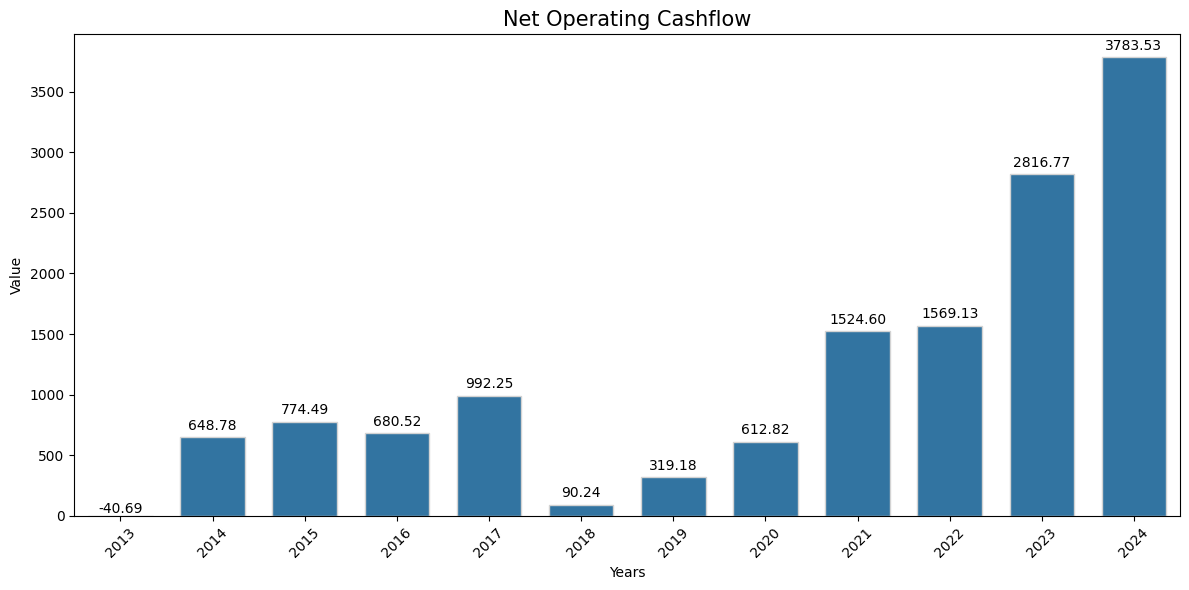

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming CashFlow is a DataFrame you already have
# Normalize values to billions
data = CashFlow['Net cash inflows/outflows from operating activities'] / 1000_000_000

# Create figure with specified size
plt.figure(figsize=(12, 6))

# Sort data by year to ensure proper ordering
sorted_indices = CashFlow['yearReport'].argsort()
years = CashFlow['yearReport'].iloc[sorted_indices]
sorted_data = data.iloc[sorted_indices]

# Create the vertical bar plot with sorted data
ax = sns.barplot(
    x=years,                # Sorted years on x-axis
    y=sorted_data,          # Sorted data values on y-axis
    edgecolor='lightgrey',
    width=0.7
)

# Set title and labels with specified font sizes
plt.title('Net Operating Cashflow', fontsize=15)
plt.xlabel('Years', fontsize=10)
plt.ylabel('Value', fontsize=10)

# Turn off grid
plt.grid(False)

# Add data labels with minimal gap above bars
for i, v in enumerate(sorted_data):
    # Much smaller offset - adjust the multiplier as needed
    offset = 0.01 * max(sorted_data)
    
    ax.text(
        i,                       # x position (bar index)
        v + offset,              # Position with minimal gap
        f'{v:.2f}',              # formatted value 
        ha='center',             # horizontal alignment
        va='bottom',             # vertical alignment
        fontsize=10
    )

# Adjust y-axis limit to make room for labels
ymax = max(sorted_data) * 1.05  # Add just 5% padding to y-axis
plt.ylim(0, ymax)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

# Save the seaborn figure
plt.savefig('./outputs/Net OCF.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [ ]:
"""
# For plotly, Add this at the end instead of fig.show()
fig.write_html("./outputs/cash_flow_chart.html")  # Saves as interactive HTML
# Or
fig.write_image("./outputs/cash_flow_chart.png")  # Requires kaleido package
"""



In [66]:
Ratio = stock.finance.ratio(period='year', lang='vi', dropna=True)
#Ratio.to_csv('./outputs/ratios.csv')
Ratio.columns.to_list()

[('Meta', 'CP'),
 ('Meta', 'Năm'),
 ('Meta', 'Kỳ'),
 ('Chỉ tiêu cơ cấu nguồn vốn', '(Vay NH+DH)/VCSH'),
 ('Chỉ tiêu cơ cấu nguồn vốn', 'Nợ/VCSH'),
 ('Chỉ tiêu cơ cấu nguồn vốn', 'TSCĐ / Vốn CSH'),
 ('Chỉ tiêu cơ cấu nguồn vốn', 'Vốn CSH/Vốn điều lệ'),
 ('Chỉ tiêu hiệu quả hoạt động', 'Vòng quay tài sản'),
 ('Chỉ tiêu hiệu quả hoạt động', 'Vòng quay TSCĐ'),
 ('Chỉ tiêu hiệu quả hoạt động', 'Số ngày thu tiền bình quân'),
 ('Chỉ tiêu hiệu quả hoạt động', 'Số ngày tồn kho bình quân'),
 ('Chỉ tiêu hiệu quả hoạt động', 'Số ngày thanh toán bình quân'),
 ('Chỉ tiêu hiệu quả hoạt động', 'Chu kỳ tiền'),
 ('Chỉ tiêu hiệu quả hoạt động', 'Vòng quay hàng tồn kho'),
 ('Chỉ tiêu khả năng sinh lợi', 'Biên EBIT (%)'),
 ('Chỉ tiêu khả năng sinh lợi', 'Biên lợi nhuận gộp (%)'),
 ('Chỉ tiêu khả năng sinh lợi', 'Biên lợi nhuận ròng (%)'),
 ('Chỉ tiêu khả năng sinh lợi', 'ROE (%)'),
 ('Chỉ tiêu khả năng sinh lợi', 'ROIC (%)'),
 ('Chỉ tiêu khả năng sinh lợi', 'ROA (%)'),
 ('Chỉ tiêu khả năng sinh lợi', 'EBIT

### Transpose the data frame to display on the web.

In [67]:
Ratio_transposed = Ratio.T
Ratio_transposed.columns=Ratio_transposed.iloc[1]
Ratio_transposed = Ratio_transposed.iloc[3:]

In [42]:
# Example: Select the 'ROE (%)' column under 'Chỉ tiêu khả năng sinh lợi'
roe = Ratio[('Chỉ tiêu khả năng sinh lợi', 'ROE (%)')]
roe


0     0.110077
1     0.133335
2     0.186927
3     0.129860
4     0.139663
5     0.155862
6     0.191602
7     0.167790
8     0.151795
9     0.131029
10    0.184132
11    0.207349
Name: (Chỉ tiêu khả năng sinh lợi, ROE (%)), dtype: float64

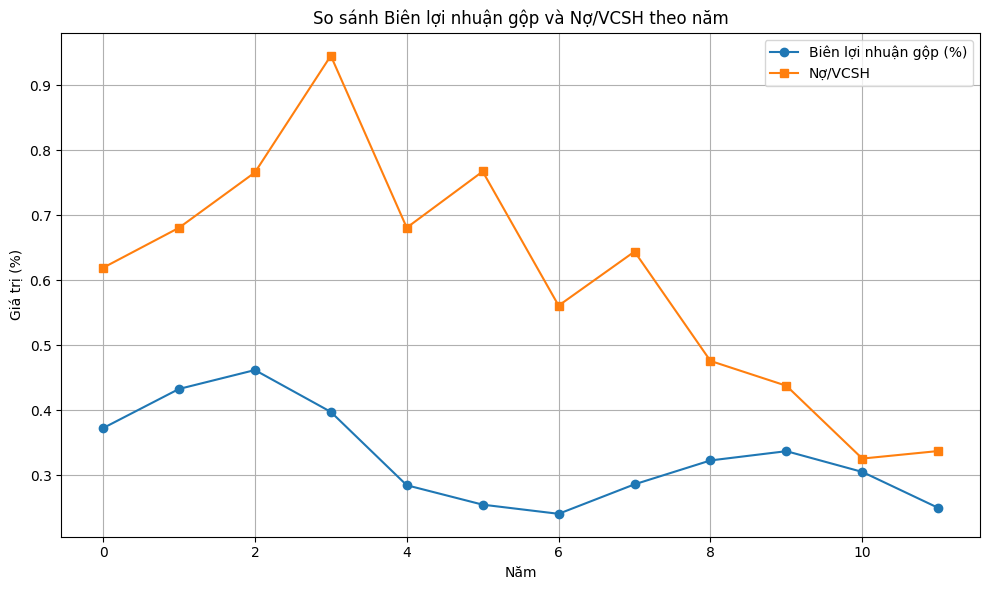

In [43]:
import matplotlib.pyplot as plt
Ratio_plot = Ratio.copy()
# Select the two columns
col1 = ('Chỉ tiêu khả năng sinh lợi', 'Biên lợi nhuận gộp (%)')
col2 = ('Chỉ tiêu cơ cấu nguồn vốn', 'Nợ/VCSH')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(Ratio_plot.index, Ratio_plot[col1], marker='o', label='Biên lợi nhuận gộp (%)')
plt.plot(Ratio_plot.index, Ratio_plot[col2], marker='s', label='Nợ/VCSH')
plt.xlabel('Năm')
plt.ylabel('Giá trị (%)')
plt.title('So sánh Biên lợi nhuận gộp và Nợ/VCSH theo năm')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

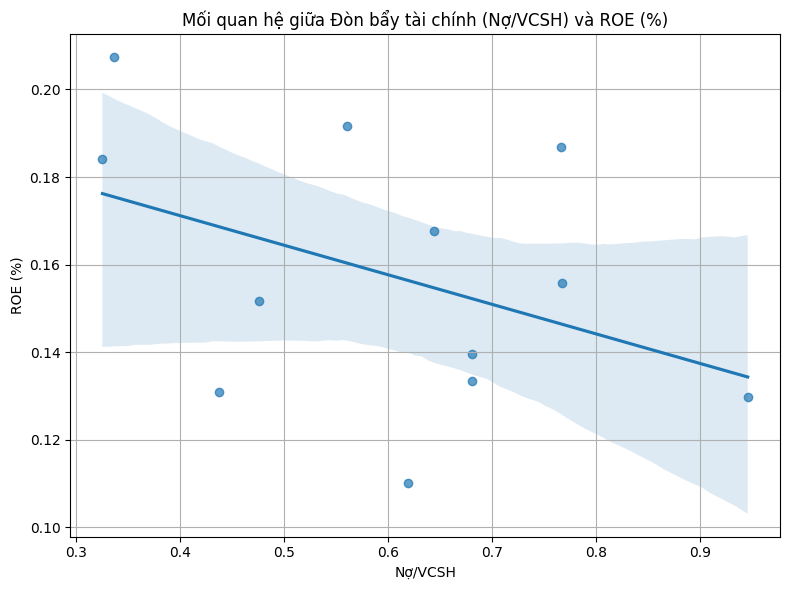

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the columns
col_roe = ('Chỉ tiêu khả năng sinh lợi', 'ROE (%)')
col_debt_equity = ('Chỉ tiêu cơ cấu nguồn vốn', 'Nợ/VCSH')

# Prepare the DataFrame for plotting
df_plot = Ratio[[col_roe, col_debt_equity]].copy()
df_plot.columns = ['ROE (%)', 'Nợ/VCSH']

# Optional: add company or year info for further analysis
if ('Meta', 'CP') in Ratio.columns:
    df_plot['CP'] = Ratio[('Meta', 'CP')]
if ('Meta', 'Năm') in Ratio.columns:
    df_plot['Năm'] = Ratio[('Meta', 'Năm')]

# Scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(data=df_plot, x='Nợ/VCSH', y='ROE (%)', scatter_kws={'alpha':0.7})
plt.title('Mối quan hệ giữa Đòn bẩy tài chính (Nợ/VCSH) và ROE (%)')
plt.xlabel('Nợ/VCSH')
plt.ylabel('ROE (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

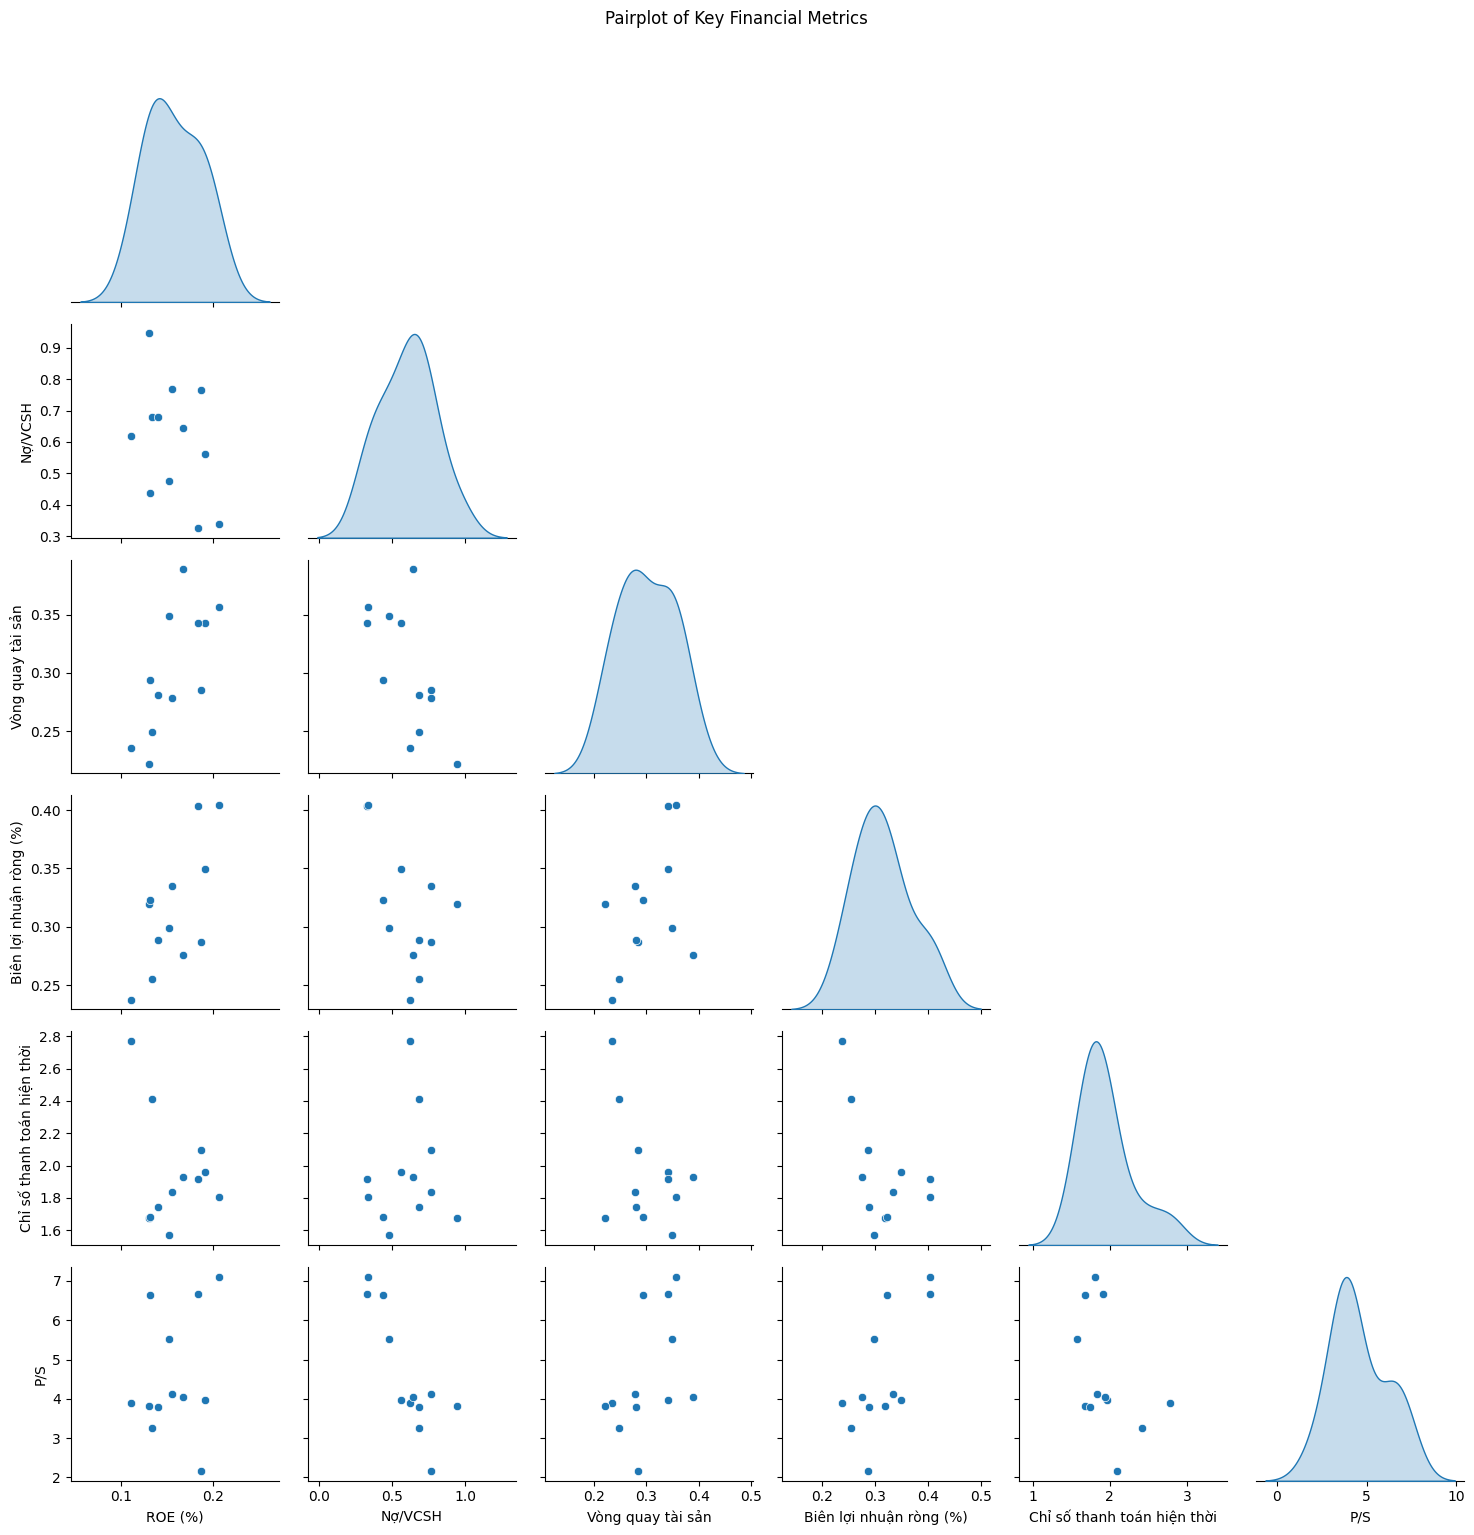

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the five most meaningful metrics (six columns for all pairwise relationships)
selected_cols = [
    ('Chỉ tiêu khả năng sinh lợi', 'ROE (%)'),
    ('Chỉ tiêu cơ cấu nguồn vốn', 'Nợ/VCSH'),
    ('Chỉ tiêu hiệu quả hoạt động', 'Vòng quay tài sản'),
    ('Chỉ tiêu khả năng sinh lợi', 'Biên lợi nhuận ròng (%)'),
    ('Chỉ tiêu thanh khoản', 'Chỉ số thanh toán hiện thời'),
    ('Chỉ tiêu định giá', 'P/S'),
]

# Subset the DataFrame
df_pair = Ratio[selected_cols].copy()

# Use only the second part of each column tuple (the metric name)
df_pair.columns = [col[1] for col in df_pair.columns]

# Optional: Remove rows with missing values for these columns
#df_pair = df_pair.dropna()

# Create the pairplot
sns.pairplot(df_pair, diag_kind='kde', corner=True)
plt.suptitle('Pairplot of Key Financial Metrics', y=1.02)
plt.tight_layout()
plt.show()

In [33]:
# import plotly.express as px
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import numpy as np
# import pandas as pd

# # Define the five most meaningful metrics (six columns for all pairwise relationships)
# selected_cols = [
#     ('Chỉ tiêu khả năng sinh lợi', 'ROE (%)'),
#     ('Chỉ tiêu cơ cấu nguồn vốn', 'Nợ/VCSH'),
#     ('Chỉ tiêu hiệu quả hoạt động', 'Vòng quay tài sản'),
#     ('Chỉ tiêu khả năng sinh lợi', 'Biên lợi nhuận ròng (%)'),
#     ('Chỉ tiêu thanh khoản', 'Chỉ số thanh toán hiện thời'),
#     ('Chỉ tiêu định giá', 'P/S'),
# ]

# # Subset the DataFrame
# df_pair = Ratio[selected_cols].copy()

# # Use only the second part of each column tuple (the metric name)
# df_pair.columns = [col[1] for col in df_pair.columns]

# # Optional: Remove rows with missing values for these columns
# #df_pair = df_pair.dropna()

# # Create a plotly figure using px.scatter_matrix for the pairplot
# fig = px.scatter_matrix(
#     df_pair,
#     dimensions=df_pair.columns,
#     title="Pairplot of Key Financial Metrics",
#     labels={col: col for col in df_pair.columns},  # Use original column names as labels
#     color_discrete_sequence=['blue'],
#     opacity=0.6
# )

# # Update layout for better appearance
# fig.update_layout(
#     title={
#         'y':0.95,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor': 'top'
#     },
#     dragmode='select',
#     width=1000,
#     height=900,
# )

# # Update traces for diagonal plots to show distributions
# for i, col in enumerate(df_pair.columns):
#     fig.update_traces(
#         diagonal_visible=True, 
#         showupperhalf=False,  # Only show lower half (like corner=True in seaborn)
#         selector=dict(dimensions=[col])
#     )

# # Update axes to include zero when appropriate
# fig.update_xaxes(showline=True, linewidth=1, linecolor='gray', mirror=True)
# fig.update_yaxes(showline=True, linewidth=1, linecolor='gray', mirror=True)

# # Show the plot
# fig.show()

# # Save to HTML for sharing
# fig.write_html("./outputs/financial_metrics_pairplot.html")
# print("Interactive pairplot saved to financial_metrics_pairplot.html")

In [34]:


# IncomeStatement.to_csv('./outputs/IncomeStatement.csv')
# BalanceSheet.to_csv('./outputs/BalanceSheet.csv') #index=False

### Transform the balance sheet from long format to wide format. 

In [45]:
def BS_wide(stock=None):
    """
    Transform balance sheet data into a wide format with years as columns and metrics as rows.
    
    Parameters:
    -----------
    stock : object, default=None
        The stock ticker object containing financial data.
        If None, will create a default stock object for REE from VCI source.
    
    Returns:
    --------
    pandas.DataFrame
        Transformed balance sheet with years as columns and financial metrics as rows
    """
    
    # Create default stock object if not provided
    if stock is None:
        stock = Vnstock().stock(symbol='REE', source='VCI')
    
    # Get the balance sheet data
    BS = stock.finance.balance_sheet(period='year', lang='en', dropna=True)
    
    # Transpose the DataFrame
    BS_wide = BS.T
    
    # Promote header by setting column names using the second row (index 1)
    BS_wide.columns = BS_wide.iloc[1]
    
    # Keep only the data rows (skip the first 3 rows)
    BS_wide = BS_wide.iloc[3:]
    
    return BS_wide

In [48]:
# BS_wide(stock)

In [58]:
BalanceSheet = stock.finance.balance_sheet(period='year', lang='en', dropna=True)
BalanceSheet_Transposed = BalanceSheet.T
BalanceSheet_Transposed.columns = BalanceSheet_Transposed.iloc[1]
BalanceSheet_Transposed = BalanceSheet_Transposed.iloc[3:]
BalanceSheet_Transposed.head()

yearReport,2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013
Cash and cash equivalents (Bn. VND),5635908856765,3022796235406,1151270686145,1830901134902,651668665185,1539577051904,1865096744967,2397186656336,960027120496,1419715236964,1036655683725,535795614565
Short-term investments (Bn. VND),1060073372989,1132366903888,1749361611727,913528242575,1328559221660,1221295628590,1138925962847,516561743653,749169998917,381491325362,249589701655,416693781070
Accounts receivable (Bn. VND),3129681988376,3780066002722,4013295895776,2986542167652,3082281525922,2137973891941,1965707145074,1130676903999,1148403790279,1368936569867,1029983840576,1002628925985
Net Inventories,1276815964044,1353834235393,1408572015872,799900814968,807507044477,987203880889,969073762968,1555629874625,1230323799872,547093860649,598432151160,544225294953
Other current assets,183295042421,235115020118,250979175707,275099902031,138617308711,112997235133,48880854277,51296869224,17305145779,30168992774,13932647991,62597867219


### Transform Income statement from long format to wide format. 

In [59]:
IncomeStatement = stock.finance.income_statement(period='year', lang='en', dropna=True)
IncomeStatement_Transpose= IncomeStatement.T
IncomeStatement_Transpose.columns = IncomeStatement_Transpose.iloc[1]
IncomeStatement_Transpose = IncomeStatement_Transpose.iloc[3:]
IncomeStatement_Transpose.head()

yearReport,2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013
Revenue (Bn. VND),8394604176003,8579347840237,9377949892489,5815207697974,5644088890450,4896700913533,5104605853407,4999235436523,3663193468551,2645193904607,2630675383788,2414569501626
Attribute to parent company (Bn. VND),1993385852649,2188316658468,2692516590418,1855079628131,1628076208584,1638893522530,1783971852557,1377087391977,1093237014487,853082411270,1061971178941,975819282949
Attribute to parent company YoY (%),-0.089078,-0.18726,0.451429,0.13943,-0.0066,-0.081323,0.295467,0.259642,0.281514,-0.196699,0.088287,0.0
Financial Income,317755694465,227055551430,186791709886,466044378716,221805860261,441971991367,303525295129,174539941233,176056435309,427537034206,459521649291,352660891530
Interest Expenses,-737977126660,-938879965835,-882746948990,-663213132564,-416425845956,-409016686932,-224927404624,-104642480959,-60159491918,-73966770226,-37413873577,-57146113236


In [61]:
BalanceSheet_Transposed.to_csv('./outputs/REE_BalanceSheet_Transposed.csv')
IncomeStatement_Transpose.to_csv('./outputs/REE_IncomeStatement_Transpose.csv')
CashFlow_transposed.to_csv('./outputs/REE_CashFlow_transposed.csv')

In [62]:
# import os
# import pandas as pd

# def save_financial_statements_to_csv(balance_sheet_df, income_statement_df, cashflow_df, output_dir='./outputs'):
#     """
#     Save financial statements DataFrames to CSV files in the specified output directory.
    
#     Parameters:
#     -----------
#     balance_sheet_df : pandas.DataFrame
#         Balance Sheet DataFrame
#     income_statement_df : pandas.DataFrame
#         Income Statement DataFrame
#     cashflow_df : pandas.DataFrame
#         Cash Flow Statement DataFrame
#     output_dir : str
#         Directory path where CSV files will be saved (default: './outputs')
#     """
    
#     # Create output directory if it doesn't exist
#     try:
#         os.makedirs(output_dir, exist_ok=True)
#         print(f"Output directory '{output_dir}' is ready.")
#     except Exception as e:
#         print(f"Error creating directory: {e}")
#         return
    
#     # Dictionary of DataFrames and their corresponding filenames
#     statements = {
#         'REE_BalanceSheet_Transposed.csv': balance_sheet_df,
#         'REE_IncomeStatement_Transpose.csv': income_statement_df,
#         'REE_CashFlow_transposed.csv': cashflow_df
#     }
    
#     # Save each DataFrame to CSV
#     for filename, df in statements.items():
#         try:
#             file_path = os.path.join(output_dir, filename)
#             df.to_csv(file_path)
#             print(f"Successfully saved {filename}")
#         except Exception as e:
#             print(f"Error saving {filename}: {e}")

# # Example usage:
# # save_financial_statements_to_csv(
# #     BalanceSheet_Transposed,
# #     IncomeStatement_Transpose,
# #     CashFlow_transposed
# # )

# Holy Fama French batman

In [83]:
factor3_url = 'https://raw.githubusercontent.com/gahoccode/Datasets/main/FamaFrench3FACTOR.csv'
factor5_url = 'https://raw.githubusercontent.com/gahoccode/Datasets/refs/heads/main/FamaFrench5FACTOR.csv'
fama_french_3f = pd.read_csv(factor3_url)
fama_french_5f= pd.read_csv(factor5_url)

# Convert the 'time' column to datetime and set as index
fama_french_3f['time'] = pd.to_datetime(fama_french_3f['time'])
fama_french_3f = fama_french_3f.set_index('time')
fama_french_5f['time'] = pd.to_datetime(fama_french_5f['time'])
fama_french_5f = fama_french_5f.set_index('time')


In [84]:
fama_french_3f.head()
fama_french_5f.head()

,rmw,cma,hml,smb_ave,rmrf,rf,month,year
time,,,,,,,,
2010-07-30,-0.002295,0.018383,0.033567,0.077511,0.005701,-0.002441,7,2010
2010-08-31,0.057870,0.038095,0.011566,-0.074865,0.023687,0.003284,8,2010
2010-09-30,-0.003626,-0.013542,-0.012890,-0.008455,0.003488,0.004061,9,2010
2010-10-29,0.050812,0.031904,-0.001663,-0.106843,0.005688,0.000431,10,2010
2010-11-30,-0.016760,0.017386,-0.025319,-0.015388,0.011717,0.018323,11,2010


In [ ]:
def three_factor(url=None):
    """
    Load and process the Fama-French 3-Factor model data.
    
    Parameters:
    ----------
    url : str, optional
        URL to the CSV file. If None, uses the default GitHub URL.
        
    Returns:
    -------
    pandas.DataFrame
        Processed Fama-French 3-Factor model data with datetime index.
    """
    if url is None:
        url = 'https://raw.githubusercontent.com/gahoccode/Datasets/main/FamaFrench3FACTOR.csv'
    
    # Load the data
    ff_3f = pd.read_csv(url)
    
    # Convert 'time' to datetime and set as index
    ff_3f['time'] = pd.to_datetime(ff_3f['time'])
    ff_3f = ff_3f.set_index('time')
    
    return ff_3f

def five_factor(url=None):
    """
    Load and process the Fama-French 5-Factor model data.
    
    Parameters:
    ----------
    url : str, optional
        URL to the CSV file. If None, uses the default GitHub URL.
        
    Returns:
    -------
    pandas.DataFrame
        Processed Fama-French 5-Factor model data with datetime index.
    """
    if url is None:
        url = 'https://raw.githubusercontent.com/gahoccode/Datasets/refs/heads/main/FamaFrench5FACTOR.csv'
    
    # Load the data
    ff_5f = pd.read_csv(url)
    
    # Convert 'time' to datetime and set as index
    ff_5f['time'] = pd.to_datetime(ff_5f['time'])
    ff_5f = ff_5f.set_index('time')
    
    return ff_5f

# # Import required libraries
# import pandas as pd

# # Load the factor data
# ff3 = three_factor()
# ff5 = five_factor()

# # Now you can work with the data
# print(ff3.head())
# print(ff5.head())  

### Add stock screener to get market cap info that only works from 9 to 5

In [88]:
# from vnstock import Screener
# params = {
#     "exchangeName": "HOSE,HNX,UPCOM",
#     "ticker": "REE"  # Replace with your stock symbol
# }
# screener = Screener()
# df = screener.stock(params=params, limit=10)
# print(df[['ticker', 'marketCap']])

from vnstock import Vnstock
company = Vnstock().stock(symbol='REE', source='VCI').company
overview = company.overview()
overview.head()



,symbol,id,issue_share,history,company_profile,icb_name3,icb_name2,icb_name4,financial_ratio_issue_share,charter_capital
0,REE,73692,471013400,- Năm 1977: Tiền thân Xí nghiệp Quốc doanh Cơ...,Công ty Cổ phần Cơ Điện Lạnh (REE) có tiền thâ...,Sản xuất & Phân phối Điện,"Điện, nước & xăng dầu khí đốt",Sản xuất & Phân phối Điện,471013400,4710134000000


In [89]:
overview.columns.to_list()

['symbol',
 'id',
 'issue_share',
 'history',
 'company_profile',
 'icb_name3',
 'icb_name2',
 'icb_name4',
 'financial_ratio_issue_share',
 'charter_capital']